In [1]:
!pip install -q transformers
!pip install -q timm

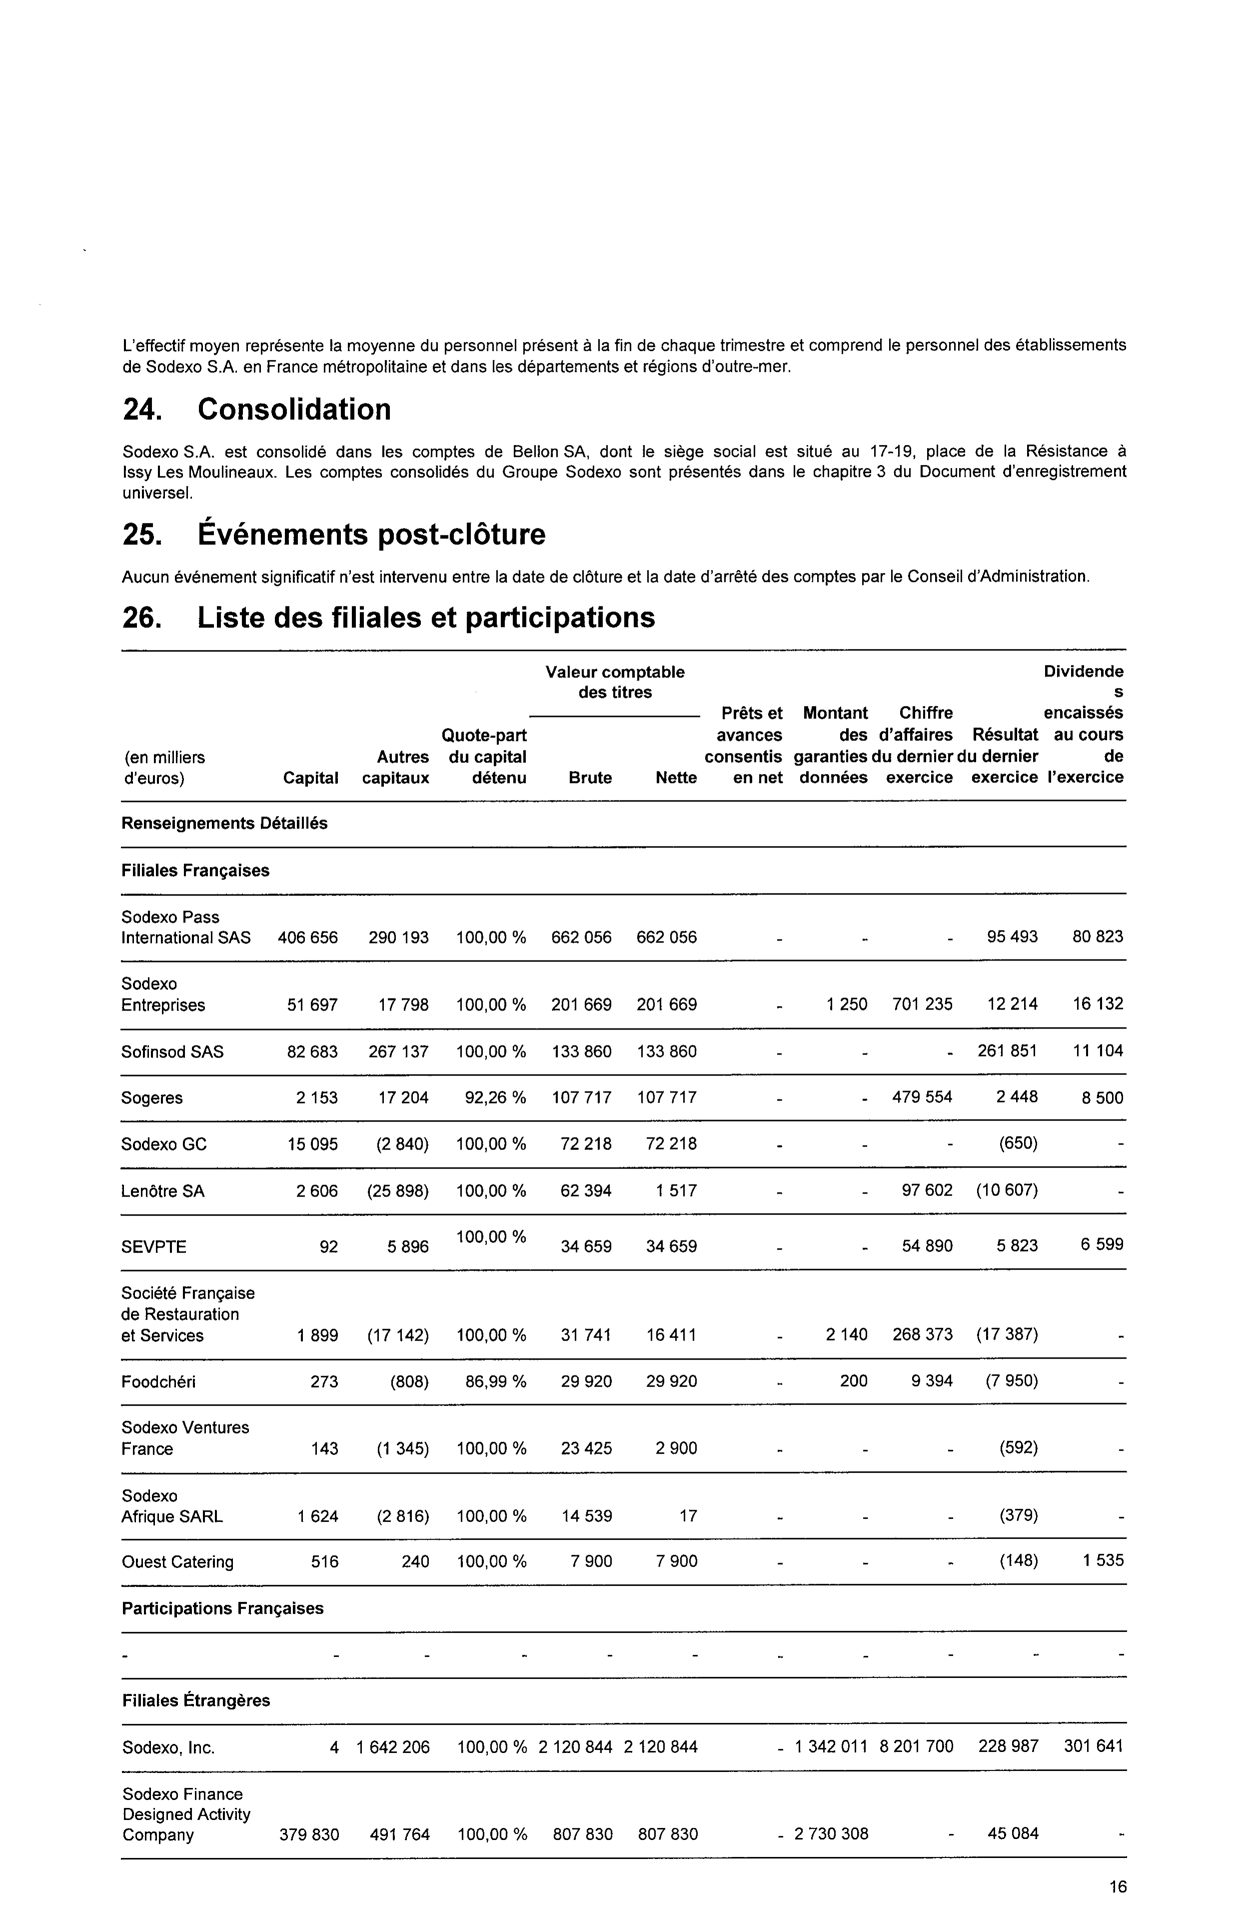

In [2]:

from huggingface_hub import hf_hub_download
from PIL import Image

file_path = "../data/marmot_data/301940219.bmp"
image = Image.open(file_path)
width, height = image.size
image.resize((int(width*0.5), int(height*0.5)))

In [3]:
from transformers import DetrFeatureExtractor

feature_extractor = DetrFeatureExtractor()
encoding = feature_extractor(image, return_tensors="pt")
encoding.keys()

/opt/mamba/lib/python3.10/site-packages/transformers/models/detr/feature_extraction_detr.py:28: FutureWarning: The class DetrFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DetrImageProcessor instead.
  warnings.warn(


dict_keys(['pixel_values', 'pixel_mask'])

In [4]:
print(encoding['pixel_values'].shape)

torch.Size([1, 3, 1228, 800])


In [5]:
from transformers import TableTransformerForObjectDetection
import torch

model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-detection")
     
with torch.no_grad():
  outputs = model(**encoding)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/onyxia/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


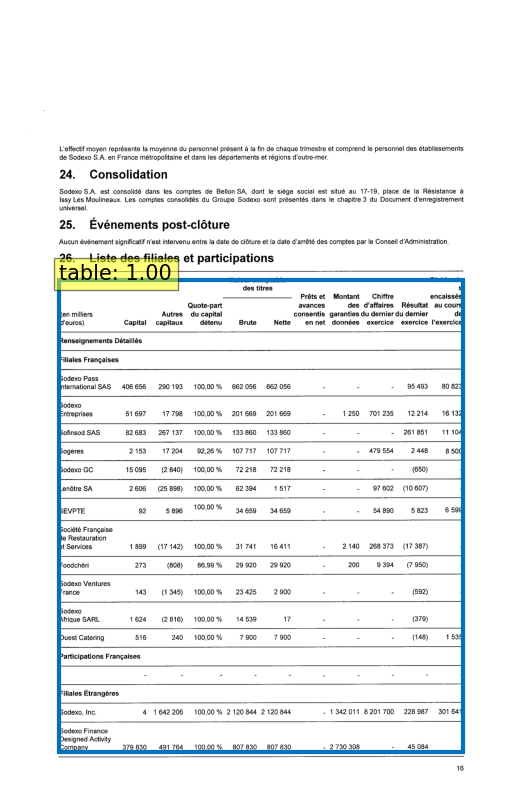

In [6]:
import matplotlib.pyplot as plt

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_img, scores, labels, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{model.config.id2label[label]}: {score:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

# rescale bounding boxes
width, height = image.size
results = feature_extractor.post_process_object_detection(outputs, threshold=0.7, target_sizes=[(height, width)])[0]

plot_results(image, results['scores'], results['labels'], results['boxes'])

## Structure recognition

In [11]:
xmin, ymin, xmax, ymax = results['boxes'].tolist()[0]

In [14]:
left_padding = 20
top_padding = 50
right_padding = 20
bottom_padding = 50 

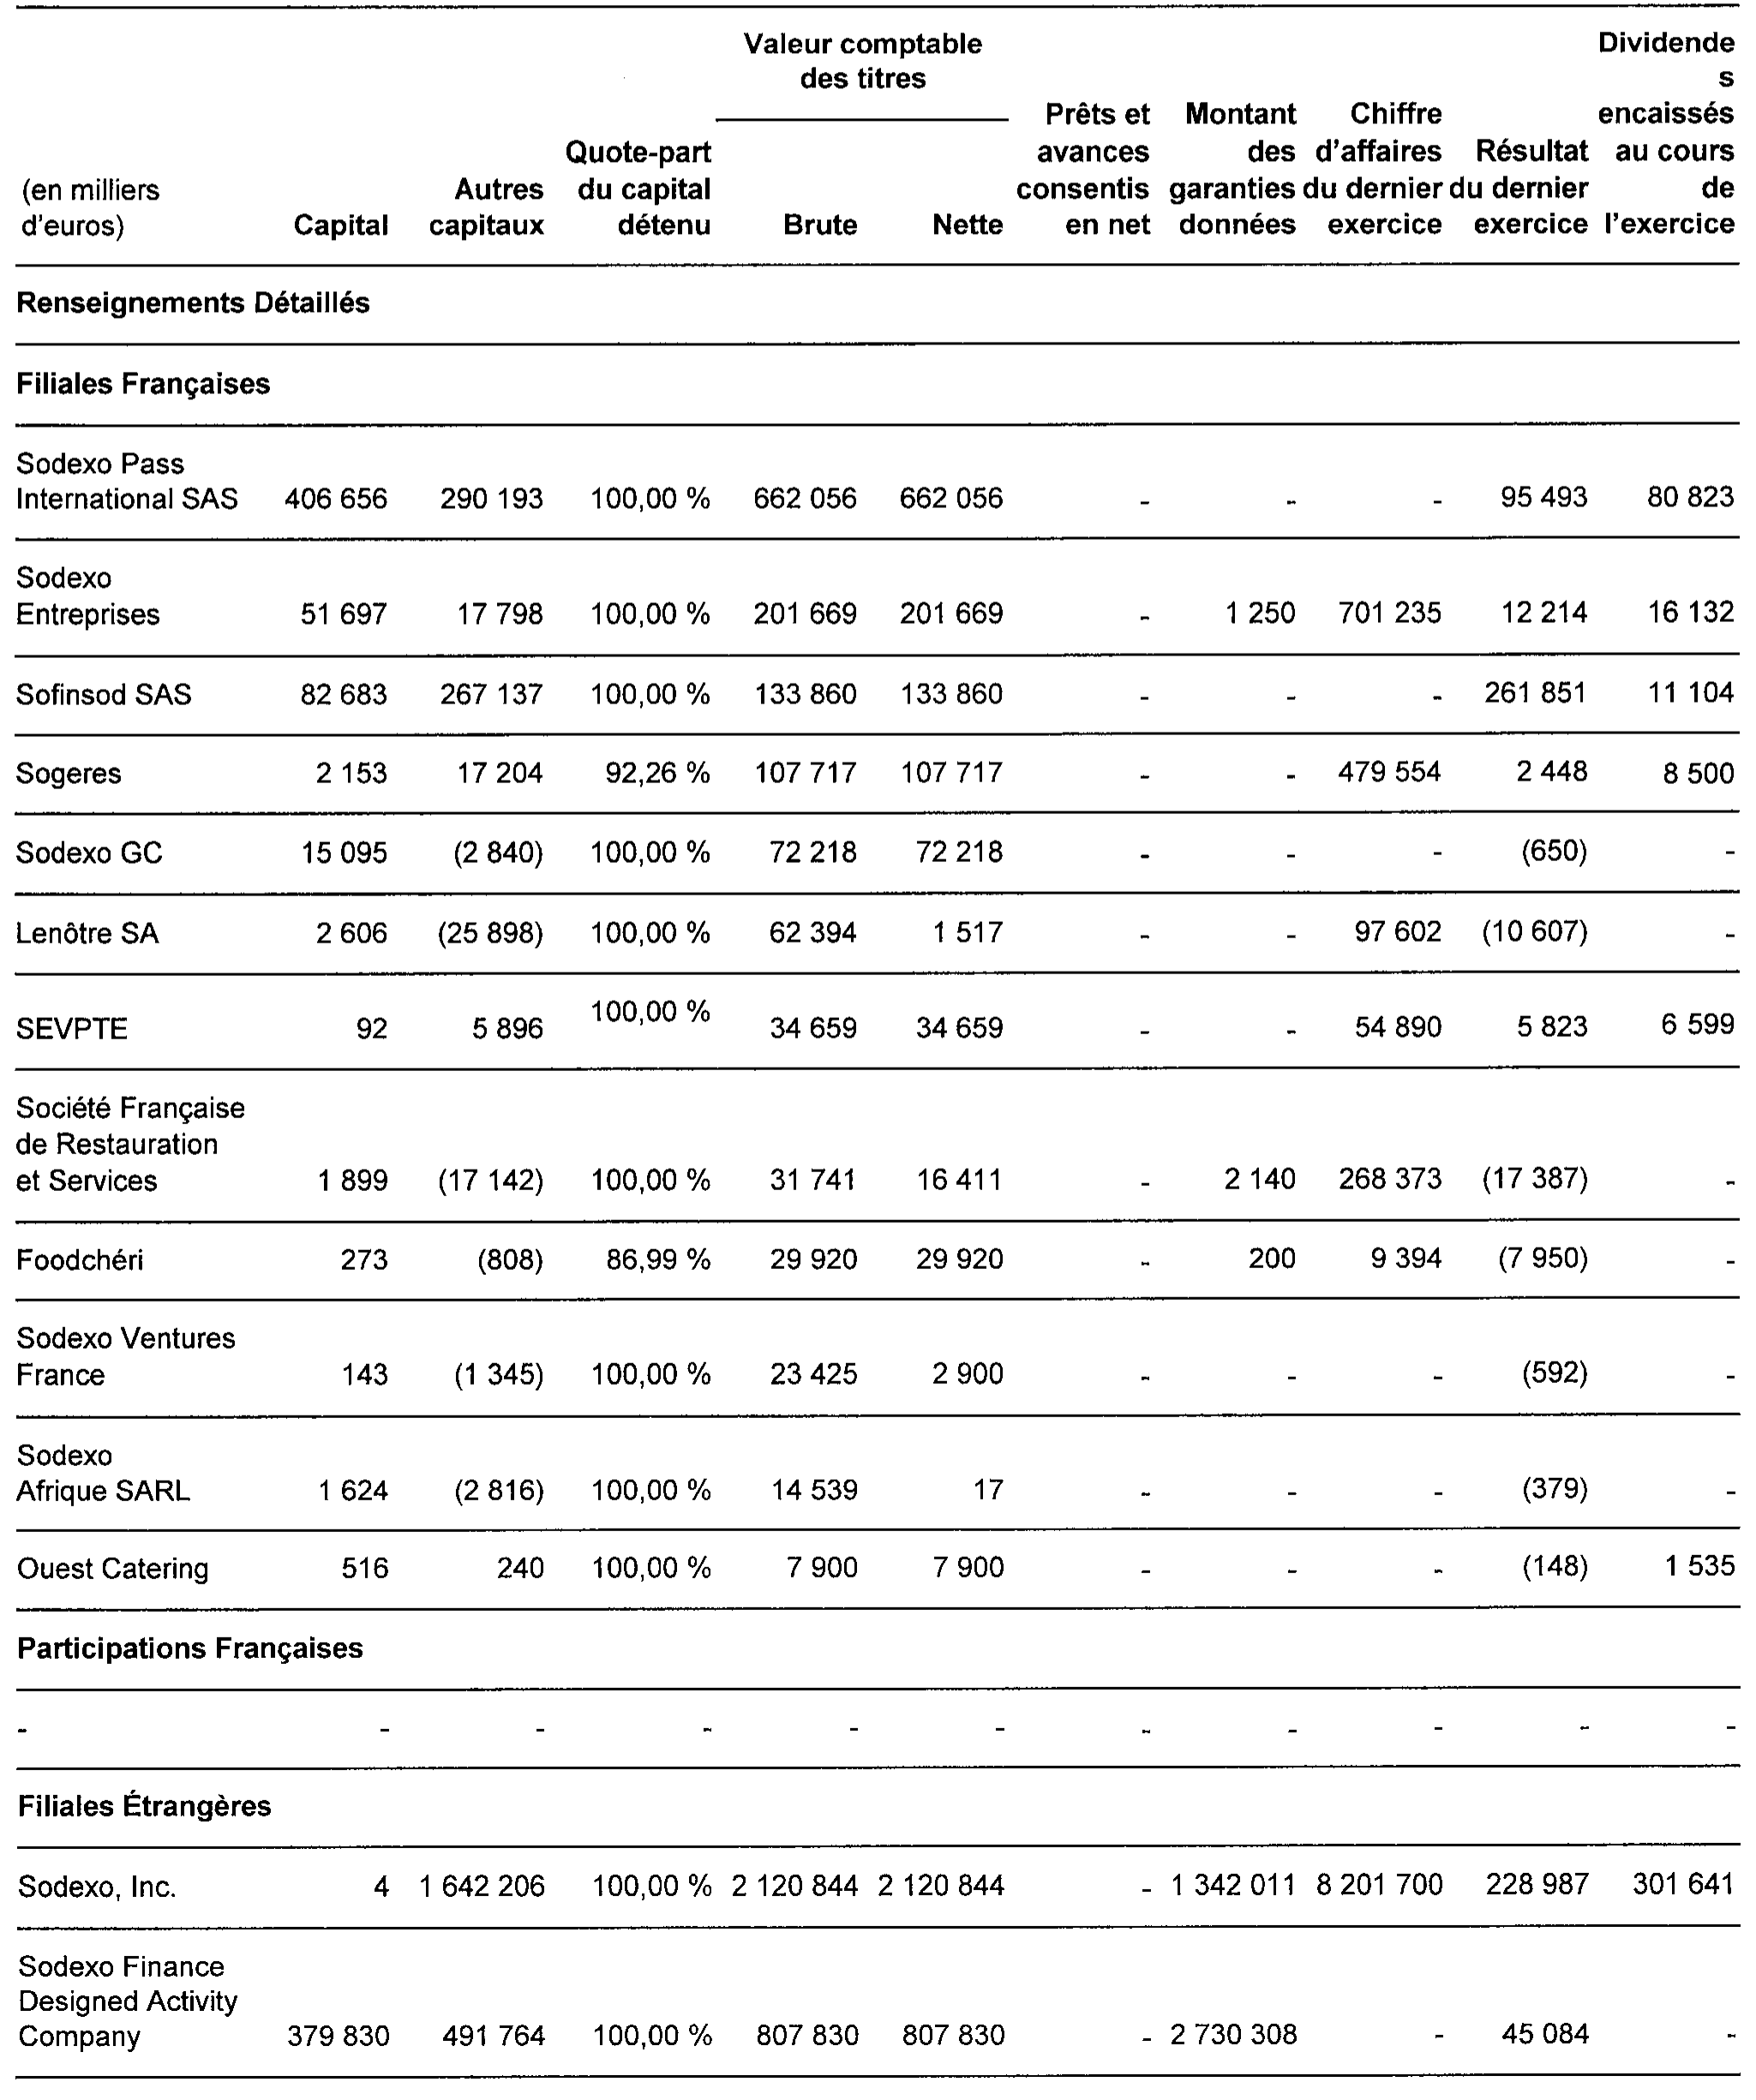

In [15]:
resized_image = image.crop((xmin - right_padding, ymin - top_padding, xmax + right_padding, ymax + bottom_padding))
resized_image

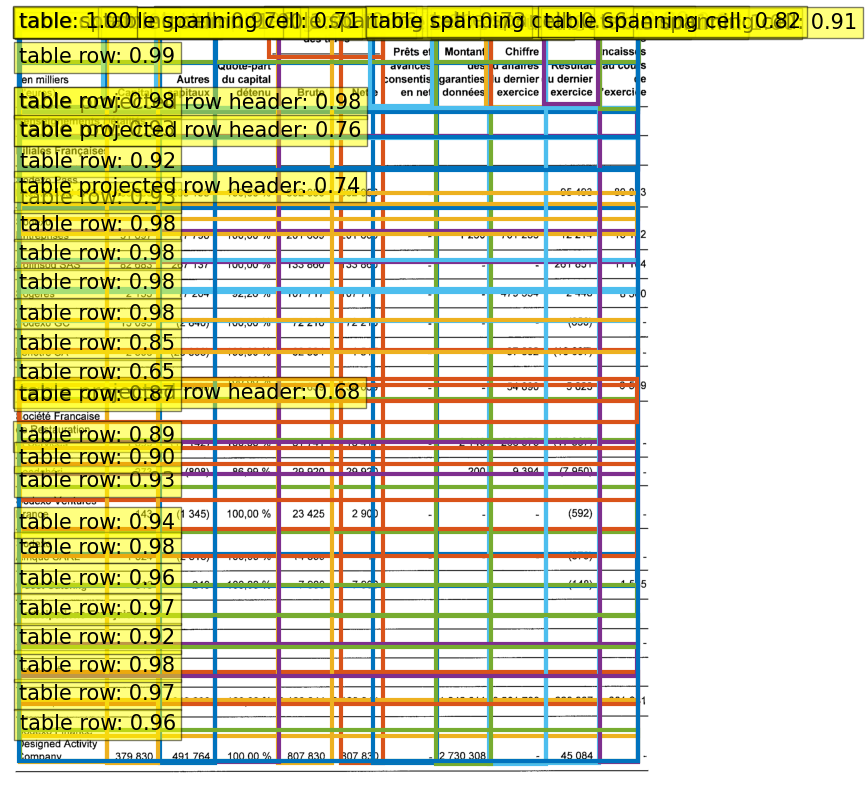

In [16]:
from transformers import TableTransformerForObjectDetection

encoding = feature_extractor(resized_image, return_tensors="pt")
encoding.keys()

model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-structure-recognition")

with torch.no_grad():
  outputs = model(**encoding)
     
target_sizes = [resized_image.size[::-1]]
results = feature_extractor.post_process_object_detection(outputs, threshold=0.6, target_sizes=target_sizes)[0]
plot_results(resized_image, results['scores'], results['labels'], results['boxes'])